# Neuquen Sediment Basin Forward Model with Variable Density

## Import Packages

In [1]:
%matplotlib inline

from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import LightSource
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from fatiando import gridder
from fatiando.mesher import Tesseroid

from tesseroid_density import tesseroid
from tesseroid_relief import TesseroidRelief

## Study Area

In [2]:
data = np.load("../../data/topography.npy")
lat, lon, topo = data[:, 0], data[:, 1], data[:, 2]
shape = (571, 457)
area = (lat.min(), lat.max(), lon.min(), lon.max())

topography = {'lon': lon, 'lat': lat, 'topo': topo,
              'shape': shape, 'area': area}

/home/santi/.anaconda2/envs/tesseroid-variable-density/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/santi/.anaconda2/envs/tesseroid-variable-density/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/santi/.anaconda2/envs/tesseroid-variable-density/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/home/santi/.anaconda2/envs/tesseroid-variable-density/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instea

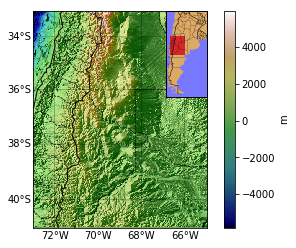

In [3]:
fig, ax = plt.subplots()

bm = Basemap(projection='merc',
             llcrnrlon=area[2],
             llcrnrlat=area[0],
             urcrnrlon=area[3],
             urcrnrlat=area[1],
             resolution='l')

topo = np.ma.masked_array(topography['topo'],
                          np.isnan(topo))
x, y = bm(topography['lon'], topography['lat'])
cmap = plt.cm.gist_earth
vmax = np.abs([np.nanmin(topo), np.nanmax(topo)]).max()
vmin = -vmax
shape = topography['shape']

# Hillshaded topography
ls = LightSource(azdeg=240, altdeg=45)
rgb = ls.shade(topo.reshape(shape), cmap,
               blend_mode='overlay', vmin=vmin, vmax=vmax)
bm.imshow(rgb)

# Proxy image for colorbar
im = bm.imshow(topo.reshape(shape), cmap=cmap)
im.remove()
plt.colorbar(im, label='m')

bm.drawcountries(linewidth=1, color='k')
bm.drawstates(linewidth=0.7, linestyle='--', color='k')
bm.drawcoastlines(color='k')
bm.drawmeridians(np.arange(-80, -50, 2), linewidth=0.5,
                 labels=[False, False, False, True])
bm.drawparallels(np.arange(-50, -30, 2), linewidth=0.5,
                 labels=[True, False, False, False])


# big map
height = "40%"
width = "23.5%"
axins = inset_axes(ax,
                   width=width,
                   height=height,
                   loc=1,
                   borderpad=0)

map2 = Basemap(projection='merc',
               llcrnrlon=360 - 75, llcrnrlat=-56,
               urcrnrlon=360 - 53, urcrnrlat=-21,
               ax=axins)
map2.drawmapboundary(fill_color='#7777ff')
map2.fillcontinents(color='#ddaa66', lake_color='#7777ff')
map2.drawcountries(linewidth=0.5)
map2.drawstates(linewidth=0.3, linestyle='--')

x1, y1 = map2(area[2], area[0])
x2, y2 = map2(area[3], area[1])
rectangle = Rectangle((x1, y1),
                      abs(x2 - x1),
                      abs(y2 - y1),
                      facecolor='C3')
axins.add_patch(rectangle)
plt.show()

## Load sediment thickness data

In [5]:
lat, lon, thickness = np.loadtxt('../../data/sediment_thickness.dat',
                                 unpack=True)
thickness = -thickness
shape = (117, 91)

area = (lat.min(), lat.max(), lon.min(), lon.max())

sediments = {'lon': lon, 'lat':lat, 'thickness': thickness,
             'shape': shape, 'area': area}

/home/santi/.anaconda2/envs/tesseroid-variable-density/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/santi/.anaconda2/envs/tesseroid-variable-density/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


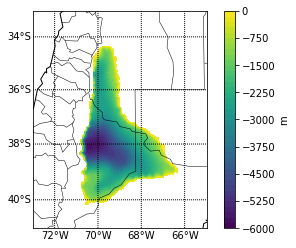

In [6]:
x, y = bm(sediments['lon'], sediments['lat'])
bm.contourf(x.reshape(sediments['shape']),
            y.reshape(sediments['shape']),
            sediments['thickness'].reshape(sediments['shape']),
            50)
bm.drawcountries()
bm.drawstates()
bm.drawcoastlines()
bm.drawmeridians(np.arange(-80, -50, 2), labels=[False, False, False, True])
bm.drawparallels(np.arange(-50, -30, 2), labels=[True, False, False, False])
plt.colorbar(label='m')
plt.show()

## Computation Grid

In [7]:
shape = (79, 81)
area = (-40.8, -33., 287, 295.)
lat, lon, height = gridder.regular(area, shape, z=50e3)
grid = {'lat': lat, 'lon': lon, 'height': height,
        'shape': shape, 'area': area}

## Tesseroid Model

In [8]:
thickness = sediments['thickness']
thickness[np.isnan(thickness)] = 0
basin = TesseroidRelief(sediments['area'], sediments['shape'],
                        thickness, 0)

## Forward Computation: Homogeneous vs Variable Density

### Homogeneous Density

In [9]:
fields = 'potential gx gy gz gxx gxy gxz gyy gyz gzz'.split()

basin.addprop('density', [-(412 + 275)/2 for i in range(basin.size)])

homogeneous = []
for field in fields:
    lat, lon, height = grid['lat'], grid['lon'], grid['height']
    %time result = getattr(tesseroid, field)(lon, lat, height, basin)
    homogeneous.append(result)

/home/santi/Documentos/geo/git-works/tesseroid-variable-density/code/tesseroid_density/tesseroid.py:169: RuntimeWarning: Encountered tesseroid with dimensions smaller than the numerical threshold (1e-6 degrees or 1e-3 m). Ignoring this tesseroid.
  warnings.warn(msg, RuntimeWarning)


CPU times: user 10.1 s, sys: 8 ms, total: 10.1 s
Wall time: 10 s
CPU times: user 23.3 s, sys: 12 ms, total: 23.3 s
Wall time: 23.3 s
CPU times: user 24.1 s, sys: 28 ms, total: 24.1 s
Wall time: 24.2 s
CPU times: user 23.2 s, sys: 28 ms, total: 23.3 s
Wall time: 23.3 s
CPU times: user 23.4 s, sys: 12 ms, total: 23.4 s
Wall time: 23.4 s
CPU times: user 23.2 s, sys: 16 ms, total: 23.2 s
Wall time: 23.1 s
CPU times: user 22.9 s, sys: 8 ms, total: 22.9 s
Wall time: 22.9 s
CPU times: user 23.6 s, sys: 4 ms, total: 23.6 s
Wall time: 23.6 s
CPU times: user 23.8 s, sys: 8 ms, total: 23.8 s
Wall time: 23.8 s
CPU times: user 23.5 s, sys: 8 ms, total: 23.5 s
Wall time: 23.4 s


In [10]:
for field, result in zip(fields, homogeneous):
    filename = "results/neuquen-basin/homogeneous/" + field
    np.save(filename, result)

### Variable Density

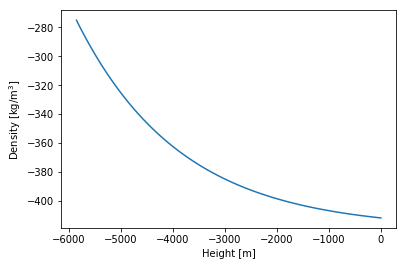

In [12]:
fields = 'potential gx gy gz gxx gxy gxz gyy gyz gzz'.split()

top, bottom = 0, thickness.min()
rho0, rho1 = -412, -275
b = 2e3
a = (rho1 - rho0)/(np.exp((abs(top - bottom))/b) - 1)
c = rho0 - a

def density(height):
    return a*np.exp(-(height)/b) + c

basin.addprop('density', [density for i in range(basin.size)])

plt.plot(np.linspace(bottom, top, 101),
         density(np.linspace(bottom, top, 101)))
plt.xlabel("Height [m]")
plt.ylabel("Density [kg/m$^3$]")
plt.show()

In [13]:
variable = []
for field in fields:
    lat, lon, height = grid['lat'], grid['lon'], grid['height']
    %time result = getattr(tesseroid, field)(lon, lat, height, basin)
    variable.append(result)

CPU times: user 4min, sys: 988 ms, total: 4min 1s
Wall time: 3min 59s
CPU times: user 4min 19s, sys: 520 ms, total: 4min 20s
Wall time: 4min 19s
CPU times: user 4min 22s, sys: 624 ms, total: 4min 22s
Wall time: 4min 21s
CPU times: user 4min 20s, sys: 568 ms, total: 4min 21s
Wall time: 4min 20s
CPU times: user 12min 18s, sys: 1.56 s, total: 12min 19s
Wall time: 12min 16s
CPU times: user 12min 25s, sys: 1.55 s, total: 12min 27s
Wall time: 12min 23s
CPU times: user 12min 41s, sys: 1.66 s, total: 12min 42s
Wall time: 12min 38s
CPU times: user 12min 30s, sys: 1.37 s, total: 12min 31s
Wall time: 12min 28s
CPU times: user 12min 29s, sys: 1.26 s, total: 12min 30s
Wall time: 12min 27s
CPU times: user 12min 45s, sys: 1.54 s, total: 12min 46s
Wall time: 12min 43s


In [14]:
for field, result in zip(fields, variable):
    filename = "results/neuquen-basin/variable/" + field
    np.save(filename, result)

## Plot Results

In [15]:
fields = 'potential gx gy gz gxx gxy gxz gyy gyz gzz'.split()
titles = ["$V$", "$g_x$", "$g_y$", "$g_z$", "$g_{xx}$", "$g_{xy}$",
          "$g_{xz}$", "$g_{yy}$", "$g_{yz}$", "$g_{zz}$"]
labels = "J/kg mGal mGal mGal Eotvos Eotvos Eotvos Eotvos Eotvos Eotvos".split()
lat, lon, height = grid['lat'], grid['lon'], grid['height']
shape = grid['shape']
area = grid['area']

variable, homogeneous = [], []
for field in fields:
    filename = "results/neuquen-basin/homogeneous/" + field + ".npy"
    homogeneous.append(np.load(filename))
    filename = "results/neuquen-basin/variable/" + field + ".npy"
    variable.append(np.load(filename))

### Results with Homogeneous Density

/home/santi/.anaconda2/envs/tesseroid-variable-density/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/santi/.anaconda2/envs/tesseroid-variable-density/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3572: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


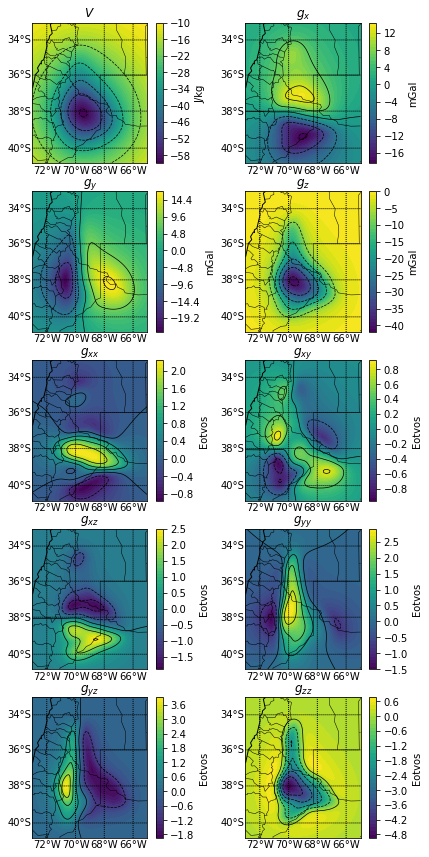

In [16]:
fig, axes = plt.subplots(5, 2, figsize=(7, 15))
axes = axes.ravel()

for result, title, label, ax in zip(homogeneous, titles, labels, axes):
    
    bm = Basemap(projection='merc',
                 llcrnrlon=area[2],
                 llcrnrlat=area[0],
                 urcrnrlon=area[3],
                 urcrnrlat=area[1],
                 resolution='l', ax=ax)
    
    x, y = bm(lon, lat)
    
    cb = bm.contourf(x.reshape(shape), y.reshape(shape),
                     result.reshape(shape), 50)
    bm.contour(x.reshape(shape), y.reshape(shape),
               result.reshape(shape), 5, colors='k',
               linewidths=0.7)
    bm.drawcountries()
    bm.drawstates()
    bm.drawcoastlines()
    bm.drawmeridians(np.arange(-80, -50, 2),
                     labels=[False, False, False, True])
    bm.drawparallels(np.arange(-50, -30, 2),
                     labels=[True, False, False, False])
    plt.colorbar(cb, ax=ax, label=label)
    ax.set_title(title)

plt.show()

### Results with Variable Density

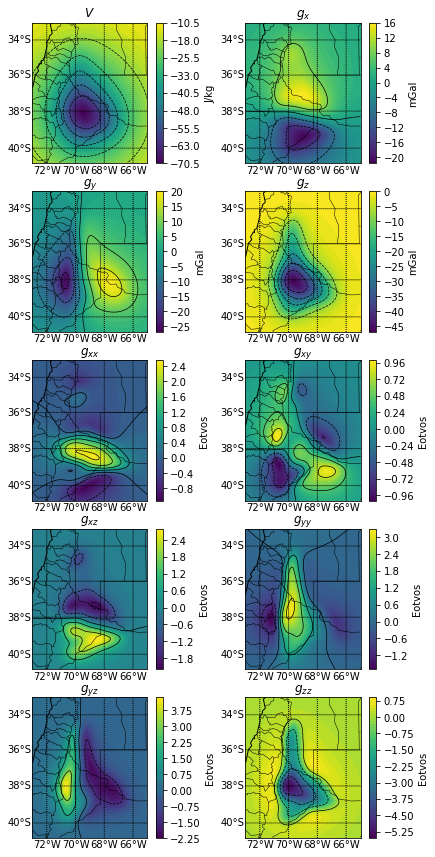

In [17]:
fig, axes = plt.subplots(5, 2, figsize=(7, 15))
axes = axes.ravel()

for result, title, label, ax in zip(variable, titles, labels, axes):
    
    bm = Basemap(projection='merc',
                 llcrnrlon=area[2],
                 llcrnrlat=area[0],
                 urcrnrlon=area[3],
                 urcrnrlat=area[1],
                 resolution='l', ax=ax)
    
    x, y = bm(lon, lat)
    
    cb = bm.contourf(x.reshape(shape), y.reshape(shape),
                     result.reshape(shape), 50)
    bm.contour(x.reshape(shape), y.reshape(shape),
               result.reshape(shape), 5, colors='k',
               linewidths=0.7)
    bm.drawcountries()
    bm.drawstates()
    bm.drawcoastlines()
    bm.drawmeridians(np.arange(-80, -50, 2),
                     labels=[False, False, False, True])
    bm.drawparallels(np.arange(-50, -30, 2),
                     labels=[True, False, False, False])
    plt.colorbar(cb, ax=ax, label=label)
    ax.set_title(title)

plt.show()

### Difference between both models

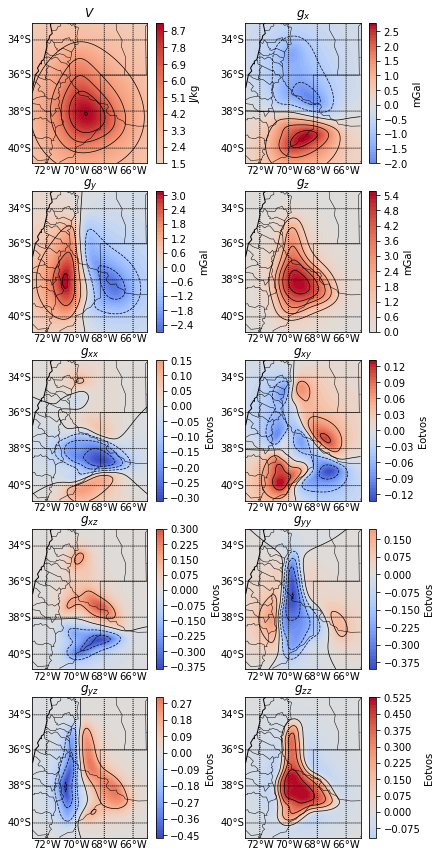

In [18]:
fig, axes = plt.subplots(5, 2, figsize=(7, 15))
axes = axes.ravel()

for var, homo, title, label, ax in zip(variable, homogeneous,
                                       titles, labels, axes):
    
    bm = Basemap(projection='merc',
                 llcrnrlon=area[2],
                 llcrnrlat=area[0],
                 urcrnrlon=area[3],
                 urcrnrlat=area[1],
                 resolution='l', ax=ax)
    
    x, y = bm(lon, lat)
    
    diff = homo - var
    vmax = np.abs(diff).max()
    
    cb = bm.contourf(x.reshape(shape), y.reshape(shape),
                     diff.reshape(shape), 50,
                     vmin=-vmax, vmax=vmax,
                     cmap='coolwarm')
    bm.contour(x.reshape(shape), y.reshape(shape),
               diff.reshape(shape), 5, colors='k',
               linewidths=0.7)
    bm.drawcountries()
    bm.drawstates()
    bm.drawcoastlines()
    bm.drawmeridians(np.arange(-80, -50, 2),
                     labels=[False, False, False, True])
    bm.drawparallels(np.arange(-50, -30, 2),
                     labels=[True, False, False, False])
    plt.colorbar(cb, ax=ax, label=label)
    ax.set_title(title)

plt.show()